#### Explore relationships between parameters from stoqs_september2013_o Parquet output

This Notebook is part of the auv-python project (private repository at https://github.com/mbari-org/auv-python). It demonstrates how to read and make interactive plots of millions of data points accessed from a STOQS database.

To execute it (for example):

```bash
    cd GitHub  # Or other appropriate directory on your computer
    git clone https://github.com/mbari-org/auv-python.git
    cd auv-python
    poetry install
    poetry shell
    cd notebooks
    jupyter notebook
    # Open this notebook and run it from your browser - interactive zooming does not work in VS Code
```

The urls in the pooch.retrieve() calls  below were generated by going to https://stoqs.mbari.org/stoqs_september2013_o/ and clicking the buttons of the Measured Parameters to be included in the Parquet file. Then clicking the "Measured Parameter Data Access" section and clicking the "Estimate requirements" button to verify that the estimated values are within the available values of the server. It may look something like this:

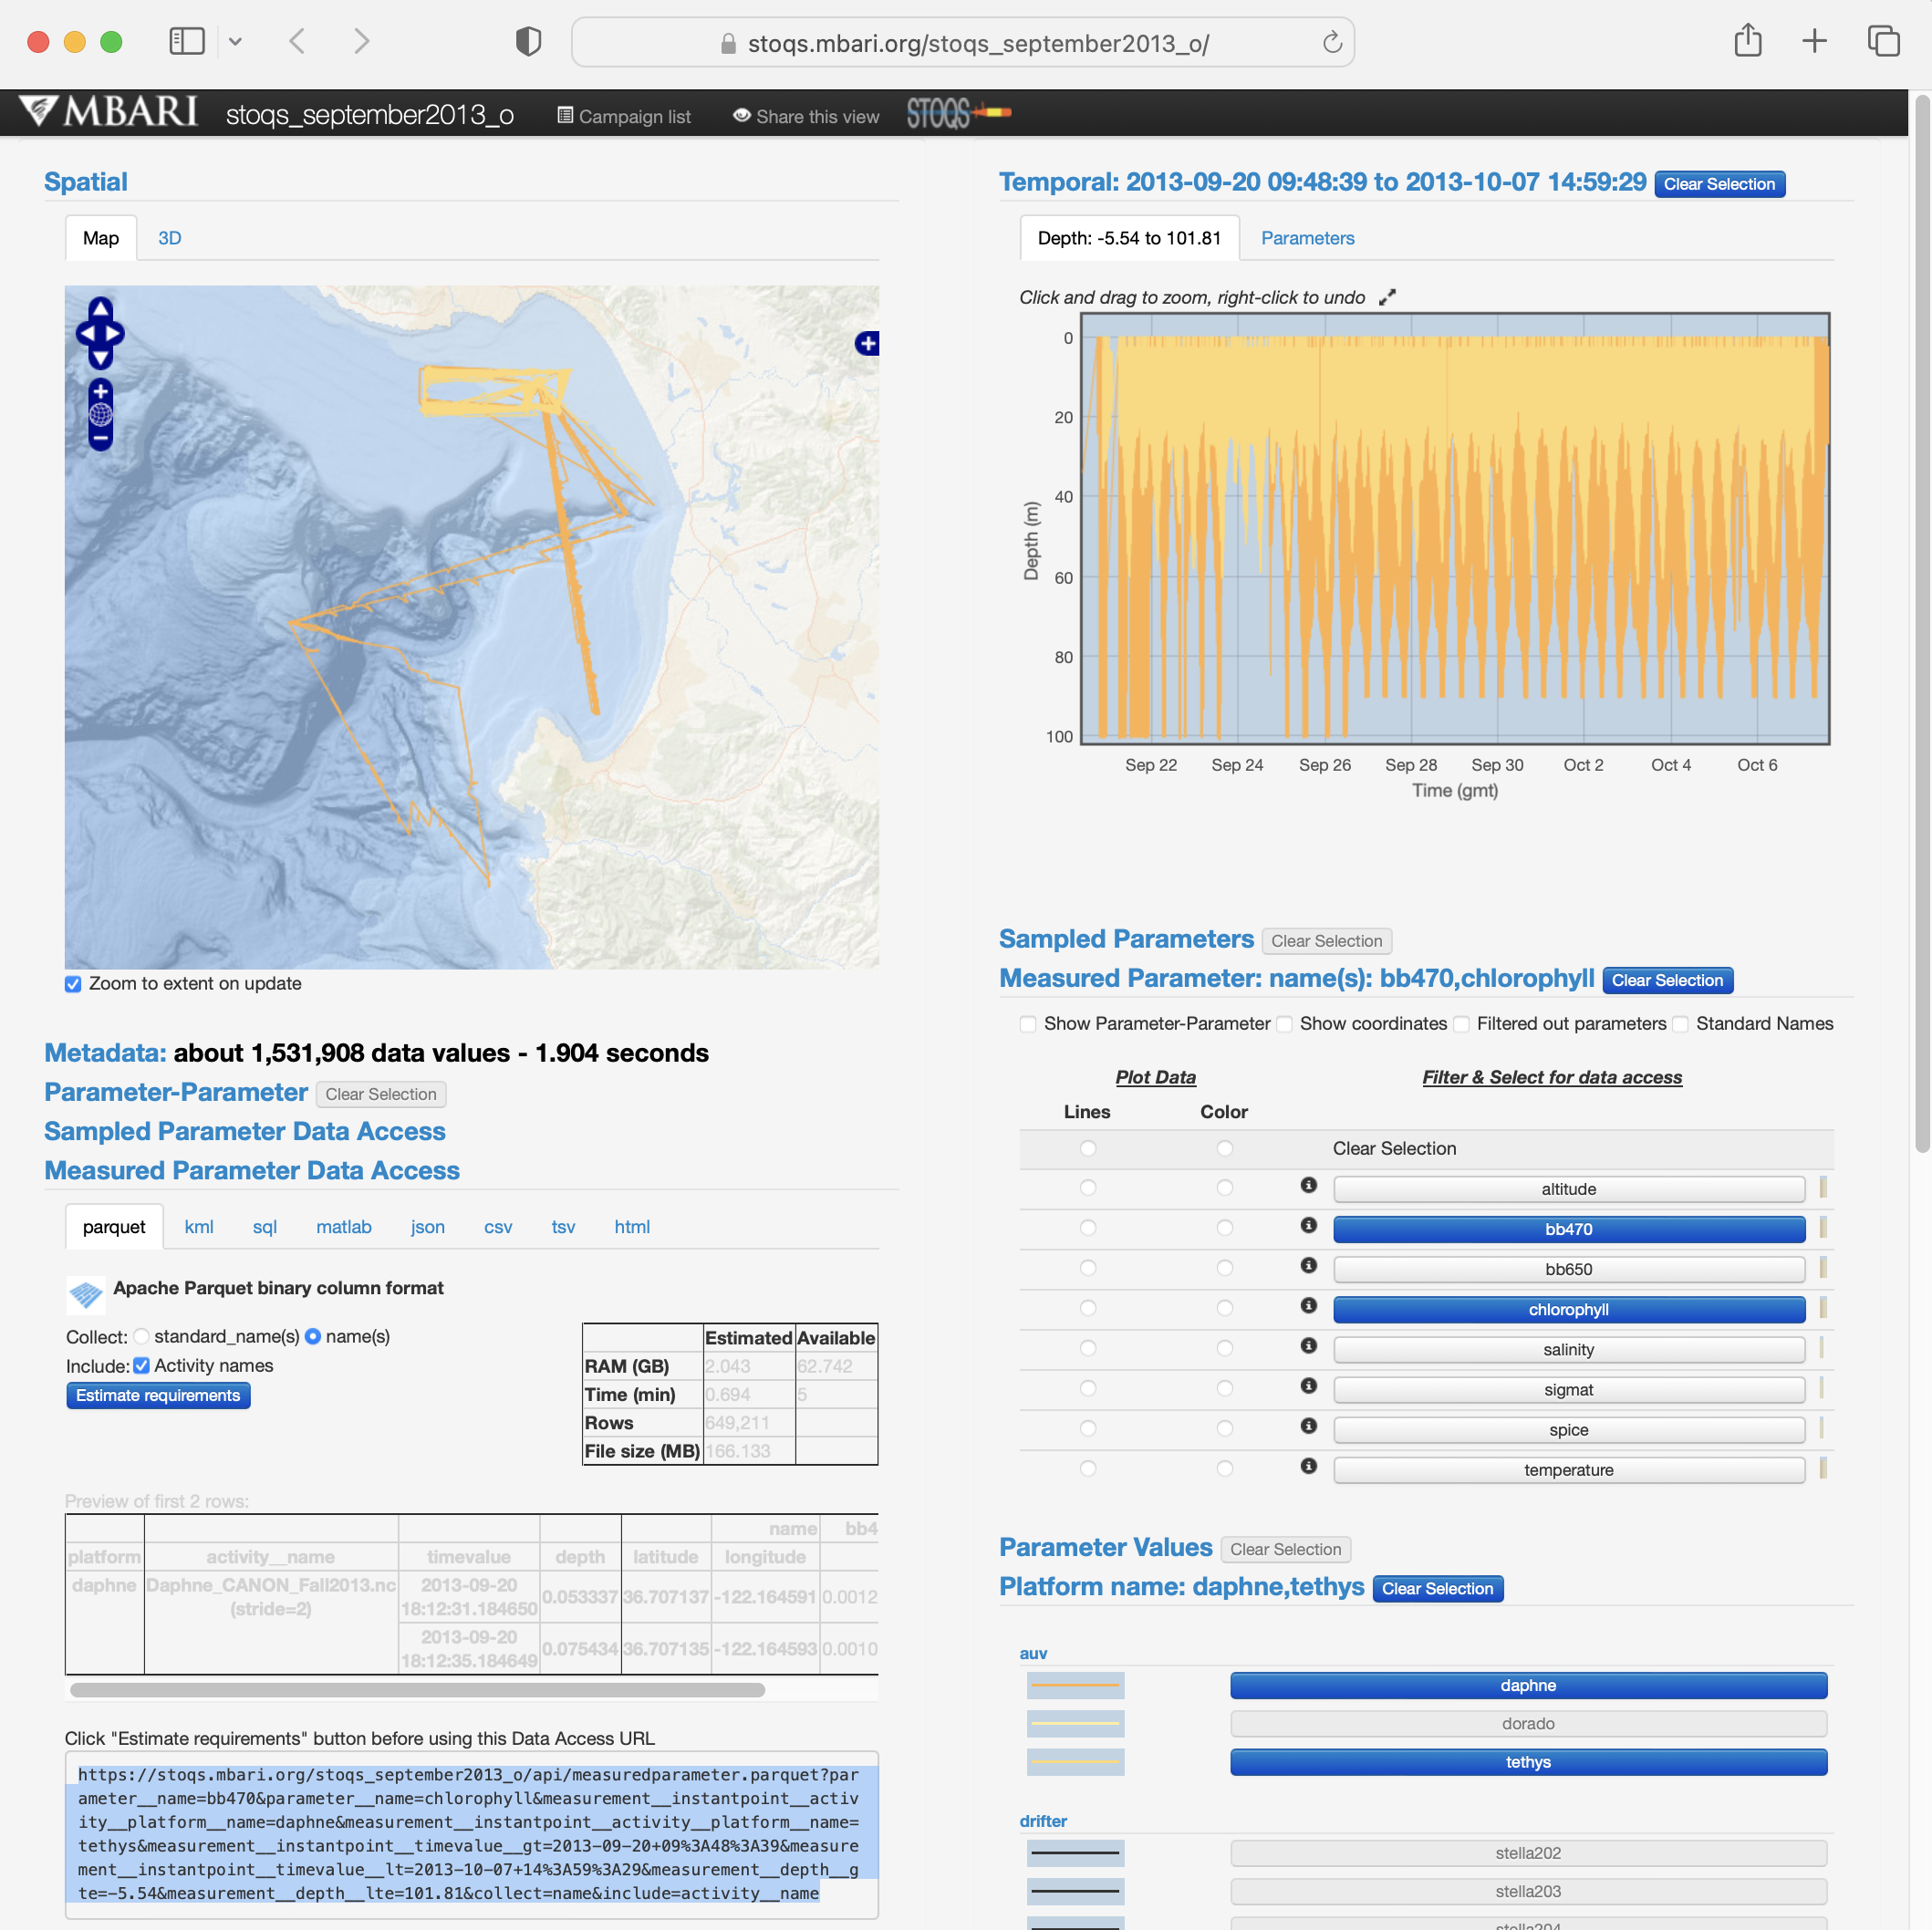

In [1]:
from IPython.display import Image
Image(filename="stoqs_parquet_ex1.png")

In [ ]:
# Do all the imports here and then load the data so that we can randomly execute
# any of the plotting cells below

import colorcet
import holoviews as hv
import hvplot.pandas
import os
import ipywidgets as widgets
import numpy as np
import pandas as pd
import panel as pn
import pooch
import statsmodels.api as sm
from bokeh.models.formatters import PrintfTickFormatter
from holoviews.operation.datashader import datashade

# New libraries needed for this file
from holoviews.operation import decimate

hv.extension("bokeh")


NOTICE: When using the below code the known_hash should not be changing. However, throughout the process of using this code the known has has change 3 separate times. All that is needed to be done is change the hash to what it it received or "got" instead of what is expected. This seems to fix the problem.

In [ ]:
# Can take several minutes to retrieve the data the first time, thereafter it's read from a local cache
data_file = pooch.retrieve(
    url="https://stoqs.mbari.org/stoqs_september2013_o/api/measuredparameter.parquet?parameter__name=altitude&parameter__name=bb470&parameter__name=bb650&parameter__name=chlorophyll&parameter__name=temperature&measurement__instantpoint__activity__platform__name=daphne&measurement__instantpoint__activity__platform__name=tethys&measurement__instantpoint__timevalue__gt=2013-09-20+09%3A48%3A39&measurement__instantpoint__timevalue__lt=2013-10-07+14%3A59%3A29&measurement__depth__gte=-5.54&measurement__depth__lte=101.81&collect=name&include=activity__name",
    known_hash="cabc41b0acec8dfd18014f1b83ec7ad6350860886857844325c984bfb299cee5",
)
df = pd.read_parquet(data_file)
df.describe()

In [ ]:
df

In [ ]:
# Remove rows that contain NaNs and save in a data frame modified
dfm = df.dropna()
dfm.describe()

In [ ]:
dfm

In [ ]:
opts = hv.opts.RGB(width=800, height=500)
pts = hv.Points(dfm, ['bb470', 'chlorophyll'])
datashade(pts).opts(opts)

This is the beginning of all new code below. Explanations will be given to display the steps achieved throughout the development progress. These steps are necessary to understand to reach final demonstration at the end.

This is data cleaning and preparing for use of data

In [ ]:
dfm.reset_index(inplace=True)#sets indexes as columns/keys

In [ ]:
dfm.keys()

In [ ]:
daphne=dfm.loc[dfm['platform']=='daphne']#creation of daphne df
tethys=dfm.loc[dfm['platform']=='tethys']#creation of tethys df

In [ ]:
daphne=daphne.dropna()#removal of remaining NaN values
tethys=tethys.dropna()#removal of remaining NaN values

In [ ]:
daphne.describe()

In [ ]:
tethys.describe()

Below is our first iteration of displaying graphs. This is the very basics of using holoviews and datashader

In [ ]:
# Displaying a datashader of timevalue vs chlorophyll within the daphne platform
opts = hv.opts.RGB(width=800, height=500)
pts = hv.Points(daphne, ['timevalue', 'chlorophyll'])

datashade(pts).opts(opts)

In [ ]:
# Displaying a datashader of timevalue vs chlorophyll within the thethys platform
opts = hv.opts.RGB(width=800, height=500)
pts = hv.Points(tethys, ['timevalue', 'chlorophyll'])

datashade(pts).opts(opts)

In [ ]:
#This is using the decimate library of holoviews to view two graphs overlaid for both platforms

#from holoviews.operation import decimate
#import datashader as ds

#This is where questions begin about how to do it correctly or fix the existing code
Data_1 = hv.Points((daphne['timevalue'],daphne['chlorophyll']),
                   kdims=[('col1', 'timevalue'), ('col2', 'chlorophyll')],
                   label="Daphne").opts(muted_alpha=0,tools=['hover'])
Data_2 = hv.Points((tethys['timevalue'],tethys['chlorophyll']),
                   kdims=[('col1', 'timevalue'), ('col2', 'chlorophyll')],
                   label="Tethys").opts(muted_alpha=0,tools=['hover'])

scatter_plot = Data_1*Data_2
decimated_scatter = decimate(scatter_plot)
decimated_scatter


In [ ]:
# A birvariate visulazation of with a selector, this is not done with 
# a selector widget but rather a groupby command.
# This graph takes quite some time to load
dfm.hvplot.bivariate(x='temperature', y='chlorophyll', width=600, 
                         groupby='platform')

This next section of the demonstration will show introduction of using widgets to the visualizations. Each visualization will have a comment to explain what is going on. All of the widgets should be updating in real time. 

The first widgets we will be looking at will be selector widgets

In [ ]:
# For the first widget we introduced was a selector widget
# With this widget we are able to create a selection for each of the parameter for each axis
# Notice we only have x available for selection, this is for our first understanding
fx = pn.widgets.Select(name='x', options=['timevalue', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650','temperature', 'chlorophyll'])


plot = dfm.hvplot(x=fx, y='chlorophyll', colorbar=True, width=600)
pn.Row(pn.WidgetBox(fx), plot)

In [ ]:
# We now push the widget to include y as well
# It is recommended that we change the first values for the selector to be different as it 
# can produce a problem where the graph displays a single line when first loaded, as seen below.
sx = pn.widgets.Select(name='x', options=['timevalue', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650','temperature', 'chlorophyll'])

sy = pn.widgets.Select(name='y', options=['timevalue', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650', 'temperature', 'chlorophyll'])

plot = dfm.hvplot(x=sx, y=sy,  colorbar=True, width=600)
pn.Row(pn.WidgetBox(sx, sy), plot)

In [ ]:
# Adding a widget to show the kind now allows us to be able to change the type of graph
fox = pn.widgets.Select(name='x', options=[ 'depth', 'chlorophyll','timevalue', 
       'latitude', 'longitude', 'altitude', 'bb470', 'bb650','temperature'])
foy = pn.widgets.Select(name='y', options=[ 'chlorophyll', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650', 'timevalue','temperature'])

fokind = pn.widgets.Select(name='kind', value='scatter', options=['bivariate', 'scatter'])

foplot = dfm.hvplot(x=fox, y=foy, kind=fokind, colorbar=True, width=600)
pn.Row(pn.WidgetBox(fox, foy, fokind), foplot)

Now you will notice that one of the selectors is now to the right of the graph for the next two cells. This is a biproduct of incorporating the selection into the graph while others are inside a widgetbox. It will not be an issue towards the end of the demonstration. 

In [ ]:
#Adding the groupby command in the plot now allows us to be able to select wich platform we want to view
fix = pn.widgets.Select(name='x', options=[ 'depth', 'chlorophyll','timevalue', 
       'latitude', 'longitude', 'altitude', 'bb470', 'bb650','temperature'])
fiy = pn.widgets.Select(name='y', options=[ 'chlorophyll', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650', 'timevalue','temperature'])
fikind = pn.widgets.Select(name='kind', value='scatter', options=['bivariate', 'scatter'])

fiplot = dfm.hvplot(x=fix, y=fiy, kind=fikind, colorbar=True, width=600, 
                    groupby='platform')
pn.Row(pn.WidgetBox(fix, fiy, fikind), fiplot)

In [ ]:
# We can achieve the same result by using a definiton and binding it to the graph
# This uses the .interactive() module, which will be important later
six = pn.widgets.Select(name='x', options=[ 'depth', 'chlorophyll','timevalue', 
       'latitude', 'longitude', 'altitude', 'bb470', 'bb650','temperature'])
siy = pn.widgets.Select(name='y', options=[ 'chlorophyll', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650', 'timevalue','temperature'])
sikind = pn.widgets.Select(name='kind',  value='scatter', options=['bivariate', 'scatter'])

siticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def siAUV_df(siticker):
    df = dfm[dfm['platform'] == siticker]
    return df
sidf =  hvplot.bind(siAUV_df, siticker).interactive()

siplot = sidf.hvplot(x=six, y=siy, kind=sikind, title=siticker)
# Notice we now drop the widgetbox, this is because it will duplicate the widgets if we do not
siplot

Using the interactive addition above we are now able to use more complex widgets binded to the graph. This is absolutely necessary to be able to use more widgets for the visualizations. These next findings with the demonstration were the most difficult to discover. This is due to many factors, but the reason behind this is mostly because the parameters must be exact and leave no room for difference, as much as we can tell from arduous exploration.

This will be the introduction of using sliders for the visualizations. We must use the interactive() parameter in order for the slider to work. We also must include the slider exactly as it is written as a mask within the dataframe for it to work. Any changes (besides masking with different terminology) CANNOT be altered, or else it will through an error.

In [ ]:
seticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def seAUV_df(seticker):
    df = dfm[dfm['platform'] == seticker]
    return df

sedf = hvplot.bind(seAUV_df, seticker).interactive()

# This is the range slider for depth, and it has to have interactive() 
# incorporated into the graph somehow for it to be able to work
se_rngSlid = pn.widgets.RangeSlider(start=dfm.depth.min(), end=dfm.depth.max(), 
                                    value=(dfm.depth.min(), dfm.depth.max()),
                                    name='Depth Range', width = 600,
                                    step=dfm.depth.max() / 200)

seplt = sedf[(sedf.depth>=se_rngSlid.param.value_start) & (sedf.depth<=se_rngSlid.param.value_end)
            ].hvplot(kind='scatter', x='depth', y='chlorophyll', grid=False, title=seticker)
seplt

In [ ]:
# Now we can do the same using a date range slider
eticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def eAUV_df(eticker):
    df = dfm[dfm['platform'] == eticker]
    return df

edf = hvplot.bind(eAUV_df, eticker).interactive()

# This is the date slider, and it has to have interactive() incorporated 
# into the graph somehow for it to be able to work
edt = pn.widgets.DatetimeRangeSlider(start=dfm.timevalue.iloc[0], end=dfm.timevalue.max(), 
                                 value=(dfm.timevalue.iloc[0], dfm.timevalue.max()),
                                 name='Date Range', width = 600)


eplt = edf[(edf.timevalue>=edt.param.value_start) & (edf.timevalue<=edt.param.value_end)
          ].hvplot(kind='scatter', x='depth', y='chlorophyll', grid=False, title=eticker)
eplt

Now that we can use sliders effectively, we can experiment with combining the sliders to output multiple of them in a single graph. Doing so will mean that we will need a chained mask. We will be separating the chain on a new line so that it can be observed.

In [ ]:
nticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def nAUV_df(nticker):
    df = dfm[dfm['platform'] == nticker]
    return df

ndf = hvplot.bind(nAUV_df, nticker).interactive()

# This is the date slider
ndt = pn.widgets.DatetimeRangeSlider(start=dfm.timevalue.iloc[0], end=dfm.timevalue.max(), 
                                 value=(dfm.timevalue.iloc[0], dfm.timevalue.max()), 
                                 name='Date Range', width = 600)
# This is the range slider for depth
n_rngSlid = pn.widgets.RangeSlider(start=dfm.depth.min(), end=dfm.depth.max(), 
                                   value=(dfm.depth.min(), dfm.depth.max()), name='Depth Range', 
                                   width = 600, step=dfm.depth.max() / 200)


nplt = ndf[
      (ndf.timevalue>=ndt.param.value_start) & (ndf.timevalue<=ndt.param.value_end)
    & (ndf.depth>=n_rngSlid.param.value_start) & (ndf.depth<=n_rngSlid.param.value_end)
          ].hvplot(kind='scatter', x='depth', y='chlorophyll', grid=False, title=nticker)
nplt

Now that we know we can chain sliders together in a mask, we should make a function that is usable for more sliders.

In [ ]:
def sliderType(colmn,range_name):
    return pn.widgets.RangeSlider(start=dfm[colmn].min(), end=dfm[colmn].max(), 
                                  value=(dfm[colmn].min(), dfm[colmn].max()), 
                                  name=range_name, width = 600, 
                                  step=dfm[colmn].max() / 200)

In [ ]:
# Incorporating the sliders into the graph with the new function
tticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def tAUV_df(tticker):
    df = dfm[dfm['platform'] == tticker]
    return df

tdf = hvplot.bind(tAUV_df, tticker).interactive()

# This is the date slider
tdt = pn.widgets.DatetimeRangeSlider(start=dfm.timevalue.iloc[0], end=dfm.timevalue.max(), 
                                 value=(dfm.timevalue.iloc[0], dfm.timevalue.max()),
                                 name='Date Range', width=600)
# This is using the new function to make a depth and chrlorophyll slider
td = sliderType("depth","Depth Slider") 
tc = sliderType("chlorophyll", "Chloro Slider")

tplt = tdf[
      (tdf.depth>=td.param.value_start) & (tdf.depth<=td.param.value_end)
    & (tdf.chlorophyll>=tc.param.value_start) & (tdf.chlorophyll<=tc.param.value_end)
    & (tdf.timevalue>=tdt.param.value_start) & (tdf.timevalue<=tdt.param.value_end)
    ].hvplot(kind='scatter', x='depth', y='chlorophyll', grid=False, title=tticker)
tplt


Now that we have done all we can with sliders, lets try to put this all together in a single visualization

In [ ]:
X = pn.widgets.Select(name='x', options=[ 'depth', 'chlorophyll','timevalue', 
       'latitude', 'longitude', 'altitude', 'bb470', 'bb650','temperature'])
Y = pn.widgets.Select(name='y', options=[ 'chlorophyll', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650', 'timevalue','temperature'])
wkind = pn.widgets.Select(name='kind', value='scatter', options=['bivariate', 'scatter'])


wticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def AUV_df(wticker):
    df = dfm[dfm['platform'] == wticker]
    return df

win = hvplot.bind(AUV_df, wticker).interactive()


wd = sliderType("depth","Depth Slider") 
wc = sliderType("chlorophyll", "Chloro Slider")
wt = pn.widgets.DatetimeRangeSlider(start=dfm.timevalue.iloc[0], end=dfm.timevalue.max(), 
                                value=(dfm.timevalue.iloc[0], dfm.timevalue.max()),
                                name='Date Range', width = 600)


plt = win[(win.depth>=wd.param.value_start) & (win.depth<=wd.param.value_end) 
        & (win.chlorophyll>=wc.param.value_start) & (win.chlorophyll<=wc.param.value_end) 
        & (win.timevalue>=wt.param.value_start) & (win.timevalue<=wt.param.value_end)
         ].hvplot(kind=wkind, x=X, y=Y, grid=False, title=wticker)
plt

In [ ]:
# And now we can do the same thing with a datashader
dsX = pn.widgets.Select(name='x', options=[ 'depth', 'chlorophyll','timevalue', 
       'latitude', 'longitude', 'altitude', 'bb470', 'bb650','temperature'])
dsY = pn.widgets.Select(name='y', options=[ 'chlorophyll', 'depth', 'latitude',
       'longitude', 'altitude', 'bb470', 'bb650', 'timevalue','temperature'])

dskind = pn.widgets.Select(name='kind', value='scatter', options=['scatter']) # Has to stay or it breaks


dsticker = pn.widgets.Select(options=['daphne', 'tethys'], name='Platform')
def dsAUV_df(dsticker):
    df = dfm[dfm['platform'] == dsticker]
    return df

dsdf = hvplot.bind(dsAUV_df, dsticker).interactive()


dsd = sliderType("depth","Depth Slider") 
dsc = sliderType("chlorophyll", "Chloro Slider")
dst = pn.widgets.DatetimeRangeSlider(start=dfm.timevalue.iloc[0], end=dfm.timevalue.max(), 
                                 value=(dfm.timevalue.iloc[0], dfm.timevalue.max()),
                                 name='Date Range', width = 600)


dsplt = dsdf[(dsdf.depth>=dsd.param.value_start) & (dsdf.depth<=dsd.param.value_end) 
          & (dsdf.chlorophyll>=dsc.param.value_start) & (dsdf.chlorophyll<=dsc.param.value_end) 
          & (dsdf.timevalue>=dst.param.value_start) & (dsdf.timevalue<=dst.param.value_end)
            ].hvplot(kind=dskind, x=dsX, y=dsY, grid=False, title=dsticker, datashade=True)
dsplt